In [1]:
import os
import sys
import gym
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf

from PPO.ppo import PPO
from A2C.a2c import A2C
from A3C.a3c import A3C
from DDQN.ddqn import DDQN
from DDPG.ddpg import DDPG

from keras.backend.tensorflow_backend import set_session
from keras.utils import to_categorical

from utils.atari_environment import AtariEnvironment
from utils.continuous_environments import Environment
from utils.networks import get_session

Using TensorFlow backend.


In [2]:
gym.logger.set_level(40)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
class attrdict(dict):
    def __init__(self, *args, **kwargs):
        dict.__init__(self, *args, **kwargs)
        self.__dict__ = self

In [4]:
args = attrdict(gpu=True, env='CartPole-v1', type='PPO', is_atari=False, 
                consecutive_frames=4, render=True, n_threads=16, nb_episodes=2_000,
               training_interval=30, batch_size=64, gather_stats=True)

In [5]:
set_session(get_session())
summary_writer = tf.summary.FileWriter(args.type + "/tensorboard_" + args.env)

In [6]:
# Environment Initialization
if(args.is_atari):
    # Atari Environment Wrapper
    env = AtariEnvironment(args)
    state_dim = env.get_state_size()
    action_dim = env.get_action_size()
elif(args.type=="DDPG"):
    # Continuous Environments Wrapper
    env = Environment(gym.make(args.env), args.consecutive_frames)
    env.reset()
    state_dim = env.get_state_size()
    action_space = gym.make(args.env).action_space
    action_dim = action_space.high.shape[0]
    act_range = action_space.high
else:
    # Standard Environments
    env = Environment(gym.make(args.env), args.consecutive_frames)
    env.reset()
    state_dim = env.get_state_size()[0]
    action_dim = gym.make(args.env).action_space.n

In [7]:
# Pick algorithm to train
if(args.type=="DDQN"):
    algo = DDQN(action_dim, state_dim, args)
elif(args.type=="A2C"):
    algo = A2C(action_dim, state_dim, args.consecutive_frames)
elif(args.type=="PPO"):
    algo = PPO(action_dim, state_dim, args.consecutive_frames)
elif(args.type=="A3C"):
    algo = A3C(action_dim, state_dim, args.consecutive_frames, is_atari=args.is_atari)
elif(args.type=="DDPG"):
    algo = DDPG(action_dim, state_dim, act_range, args.consecutive_frames)






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 2)                 258       
Total params: 17,410
Trainable params: 17,410
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
d

## train

In [8]:
# Train
rewards, actor_losses, critic_losses = algo.train(env, args, summary_writer)

Episode:  1




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Episode:  110
Episode:  225
Episode:  352
Episode:  492
Episode:  642
Episode:  779
Episode:  922
Episode:  1059
Episode:  1205
Episode:  1358
Episode:  1512
Episode:  1671
Episode:  1835
Episode:  2006
Episode:  2166
Episode:  2333
Episode:  2492
Episode:  2664
Episode:  2831
Episode:  3000
Episode:  3168
Episode:  3330
Episode:  3487
Episode:  3648
Episode:  3813
Episode:  3968
Episode:  4125
Episode:  4284
Episode:  4444
Episode:  4595
Episode:  4759
Episode:  4926
Episode:  5088
Episode:  5254
Episode:  5421
Episode:  5591
Episode:  5762
Episode:  5931
Episode:  6096
Episode:  6265
Episode:  6425
Episode:  6591
Episode:  6759
Episode:  6923
Episode:  7085
Episode:  7249
Episode:  7415
Episode:  7582
Episode:  7750
Episode:  7914
Episode:  8079
Episode:  8238
Episode:  8398
Episode:  8554
Episode:  8725
Episode:  8889
Episode:  9041
Episode:  9204
Episode:  9363
Episode:  

Episode:  23863
Episode:  23872
Episode:  23880
Episode:  23887
Episode:  23894
Episode:  23902
Episode:  23908
Episode:  23914
Episode:  23920
Episode:  23926
Episode:  23931
Episode:  23937
Episode:  23943
Episode:  23949
Episode:  23954
Episode:  23960
Episode:  23965
Episode:  23970
Episode:  23976
Episode:  23981
Episode:  23986
Episode:  23992
Episode:  23998
Episode:  24006
Episode:  24012
Episode:  24018
Episode:  24024
Episode:  24030
Episode:  24036
Episode:  24041
Episode:  24046
Episode:  24052
Episode:  24057
Episode:  24062
Episode:  24067
Episode:  24072
Episode:  24077
Episode:  24082
Episode:  24087
Episode:  24092
Episode:  24097
Episode:  24103
Episode:  24108
Episode:  24113
Episode:  24118
Episode:  24123
Episode:  24128
Episode:  24133
Episode:  24138
Episode:  24143
Episode:  24148
Episode:  24153
Episode:  24158
Episode:  24163
Episode:  24168
Episode:  24173
Episode:  24178
Episode:  24183
Episode:  24188
Episode:  24193
Episode:  24198
Episode:  24204
Episode:

Episode:  26595
Episode:  26602
Episode:  26607
Episode:  26613
Episode:  26620
Episode:  26628
Episode:  26635
Episode:  26641
Episode:  26647
Episode:  26654
Episode:  26659
Episode:  26665
Episode:  26670
Episode:  26675
Episode:  26680
Episode:  26686
Episode:  26691
Episode:  26696
Episode:  26702
Episode:  26707
Episode:  26712
Episode:  26717
Episode:  26723
Episode:  26728
Episode:  26733
Episode:  26738
Episode:  26743
Episode:  26748
Episode:  26753
Episode:  26758
Episode:  26763
Episode:  26768
Episode:  26774
Episode:  26779
Episode:  26784
Episode:  26789
Episode:  26794
Episode:  26799
Episode:  26806
Episode:  26812
Episode:  26818
Episode:  26825
Episode:  26831
Episode:  26837
Episode:  26843
Episode:  26848
Episode:  26854
Episode:  26859
Episode:  26864
Episode:  26869
Episode:  26874
Episode:  26879
Episode:  26884
Episode:  26890
Episode:  26895
Episode:  26900
Episode:  26906
Episode:  26911
Episode:  26916
Episode:  26922
Episode:  26928
Episode:  26935
Episode:

KeyboardInterrupt: 

In [9]:
rewards = algo.rewards

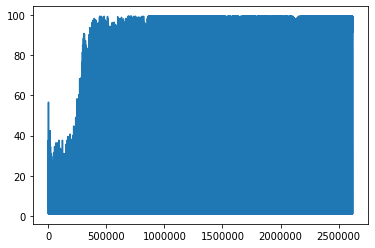

In [11]:
import matplotlib.pyplot as plt
aux_rewards = []
for i in range(len(rewards)):
    for j in range(len(rewards[i])):
        aux_rewards.append(rewards[i][j])
    
plt.plot(aux_rewards)
plt.show()

In [12]:
algo.save_weights("saved_models/PPO")

## test

In [ ]:
# Pick algorithm to test
if(args.type=="DDQN"):
    algo = DDQN(action_dim, state_dim, args)
elif(args.type=="A2C"):
    algo = A2C(action_dim, state_dim, args.consecutive_frames)
elif(args.type=="PPO"):
    algo = PPO(action_dim, state_dim, args.consecutive_frames)
elif(args.type=="A3C"):
    algo = A3C(action_dim, state_dim, args.consecutive_frames, is_atari=args.is_atari)
elif(args.type=="DDPG"):
    algo = DDPG(action_dim, state_dim, act_range, args.consecutive_frames)

In [ ]:
algo.load_weights("saved_models/PPO_LR_0.0001_actor.h5", "saved_models/PPO_LR_0.0001_critic.h5")

In [ ]:
# Reset episode
num_test_int = 10
global_info = []

for i in range(num_test_int):
    time, cumul_reward, done = 0, 0, False
    old_state = env.reset()
    
    while not done:
        env.render()
        # Actor picks an action (following the policy)
        a = algo.policy_action(old_state)
        # Retrieve new state, reward, and whether the state is terminal
        new_state, r, done, _ = env.step(a)
        # Update current state
        old_state = new_state
        cumul_reward += r
        time += 1
        
        if done: 
            global_info.append({
                cumul_reward
            })